# Flow-Temp Model Test

## Import dependencies and data

In [39]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.linear_model import Ridge, LinearRegression, Lasso

In [40]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [70]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [71]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X_default'),
#     ('flow', 'TA01_SP102_relative'),
#     ('flow', 'DC_SP105_relative'),
#     ('flow', 'DC_SP106_relative'),
#     ('flow', 'DC_SP107_relative'),
#     ('flow', 'DC_SP110_relative'),
    ('flow', 'TA01_SP102_absolute'),
    ('flow', 'DC_SP105_absolute'),
    ('flow', 'DC_SP106_absolute'),
    ('flow', 'DC_SP107_absolute'),
    ('flow', 'DC_SP110_absolute'),
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [43]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID               
flow          TA01_GP101_default          0
temperatures  TA01_GT10X_GM10X            0
              DC_GT301_damped             0
              DC_GT401_GM401              0
setpoints     TA01_GT10X_GM10X_default    0
flow          TA01_SP102_absolute         0
              DC_SP105_absolute           0
              DC_SP106_absolute           0
              DC_SP107_absolute           0
              DC_SP110_absolute           0
dtype: int64





In [44]:
# describe cols
data.describe().transpose()

count          mean           std  \
category     sensor_ID                                                        
flow         TA01_GP101_default        166921.0   2354.738858    631.850358   
temperatures TA01_GT10X_GM10X          166921.0     20.287643      1.043412   
             DC_GT301_damped           166921.0     -5.166278      6.829758   
             DC_GT401_GM401            166921.0     49.677559      3.609970   
setpoints    TA01_GT10X_GM10X_default  166921.0     20.330416      0.712380   
flow         TA01_SP102_absolute       166921.0  14020.817728  20710.049968   
             DC_SP105_absolute         166921.0  14009.519222  19576.332200   
             DC_SP106_absolute         166921.0   4196.093757   9411.977186   
             DC_SP107_absolute         166921.0   3143.174789   3383.031988   
             DC_SP110_absolute         166921.0   5590.956159   3116.996965   

                                        min     25%     50%      75%      max  
category     sensor_ID                                                         
flow         TA01_GP101_default         0.0  1864.0  2114.8   2718.4   4206.6  
temperatures TA01_GT10X_GM10X           0.0    19.9    20.1     20.5     29.2  
             DC_GT301_damped          -21.6   -10.8    -3.8      0.5      8.4  
             DC_GT401_GM401             0.0    49.0    50.4     51.6     55.9  
setpoints    TA01_GT10X_GM10X_default   0.0    20.0    20.0     20.0     22.0  
flow         TA01_SP102_absolute        0.0     0.0     0.0  28459.0  65534.0  
             DC_SP105_absolute          0.0     0.0     0.0  28858.0  65534.0  
             DC_SP106_absolute          0.0     0.0     0.0   5744.0  65534.0  
             DC_SP107_absolute          0.0     0.0     0.0   6633.0  15120.0  
             DC_SP110_absolute          0.0  4771.0  6980.0   7603.0  17720.0

## Process / transform variables 

### ANVÄND IST. RELATIVA SKILLNADER?!

In [72]:
# STEPS
fsteps = 20
bsteps = 40

# remove level shift from setpoints change
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
                                                - (data.setpoints.TA01_GT10X_GM10X_default - 20.0)

# create forward temp variable
data[('temperatures', 'TA01_GT10X_GM10X_forward')] = data.temperatures.TA01_GT10X_GM10X.shift(periods=-fsteps)

# create first differences f. FORWARD GH temp
data[('temperatures', 'TA01_GT10X_GM10X_fdiff')] = data.temperatures.TA01_GT10X_GM10X_forward.diff(periods=bsteps)

# create first differences f. DC temp
data[('temperatures', 'DC_GT401_GM401_diff')] = data.temperatures.DC_GT401_GM401.diff(periods=bsteps)

# create first differences f. OUT temp
data[('temperatures', 'DC_GT301_damped_diff')] = data.temperatures.DC_GT301_damped.diff(periods=40)

# create first differences f. DC flow
#data[('flow', 'TA01_GP101_default_fdiff1')] = data.flow.TA01_GP101_default.diff(periods=steps * 1.5)
data[('flow', 'TA01_GP101_default_diff')] = data.flow.TA01_GP101_default.diff(periods=bsteps)
#data[('flow', 'TA01_GP101_default_fdiff3')] = data.flow.TA01_GP101_default.diff(periods=steps // 2)

# create first diffs f. flows
data[('flow', 'TA01_SP102_absolute_diff')] = data.flow.TA01_SP102_absolute.diff(periods=bsteps)
data[('flow', 'DC_SP105_absolute_diff')] = data.flow.DC_SP105_absolute.diff(periods=bsteps)
data[('flow', 'DC_SP106_absolute_diff')] = data.flow.DC_SP106_absolute.diff(periods=bsteps)
data[('flow', 'DC_SP107_absolute_diff')] = data.flow.DC_SP107_absolute.diff(periods=bsteps)
data[('flow', 'DC_SP110_absolute_diff')] = data.flow.DC_SP110_absolute.diff(periods=bsteps)

# get mixed effects
def col_transf(col):
    
    # transform all nums to at least one.
    col = col.apply(lambda vals: max(vals, 1))
    
    return col

data[('mixed', 'flow_temp')] = col_transf(data[('temperatures', 'DC_GT401_GM401')]) \
                                * col_transf(data[('flow', 'TA01_GP101_default')])

data[('mixed', 'flow_temp_diff')] = data.mixed.flow_temp.diff(periods=bsteps)

# crop dataset
data = data.iloc[bsteps:-fsteps].copy()

### Plot pairwise correlation matrix

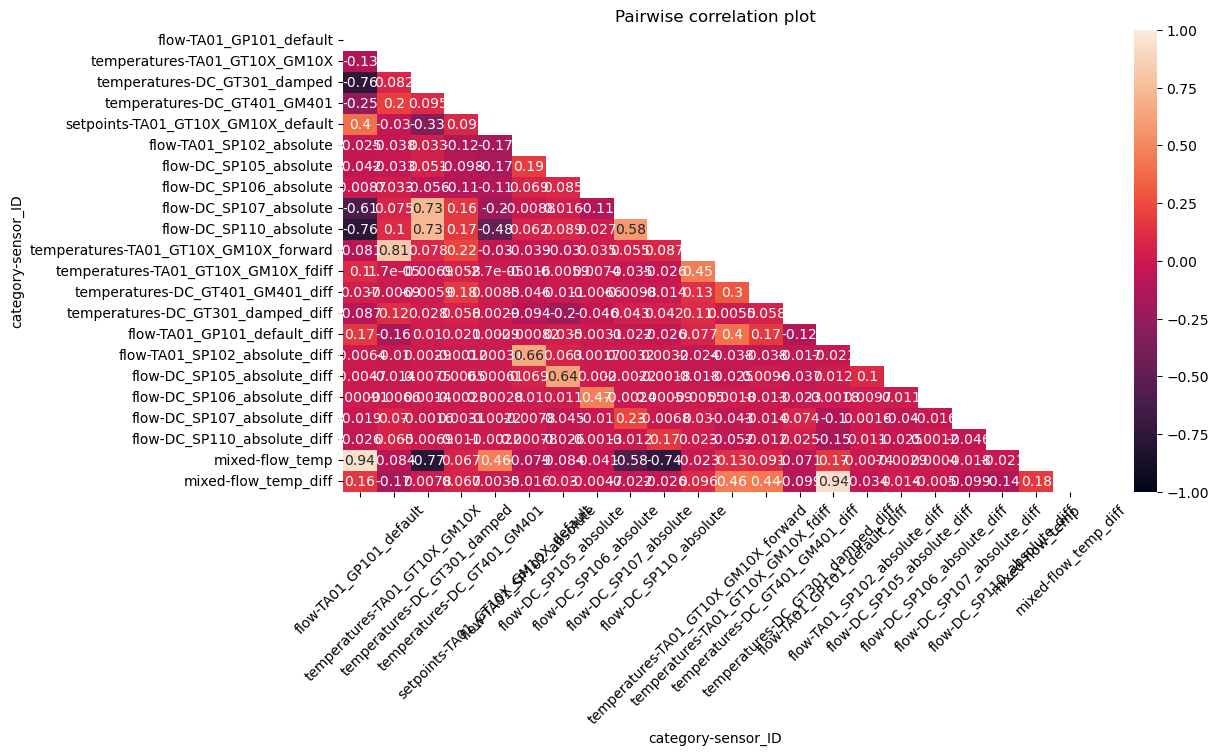

In [46]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

### Data selection and whitening

In [47]:
# Define model variables
model_vars = [
    ('temperatures', 'TA01_GT10X_GM10X_fdiff'),
    ('temperatures', 'DC_GT401_GM401_diff'),
    ('temperatures', 'DC_GT301_damped_diff'),
    ('flow', 'TA01_GP101_default_diff'),
    ('mixed', 'flow_temp_diff'),
    ('flow', 'TA01_SP102_absolute_diff'),
    ('flow', 'DC_SP105_absolute_diff'),
    ('flow', 'DC_SP106_absolute_diff'),
    ('flow', 'DC_SP107_absolute_diff'),
    ('flow', 'DC_SP110_absolute_diff'),
]

# filter data
data = data[model_vars].copy()

In [73]:
# normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

### Create sequences

In [49]:
# N step range
n_steps = bsteps + fsteps

# get flagged dates
data['day'] = data.index.get_level_values(1).values
data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

# remove erroneous rows
data = data[data.date_flag == 0]

# delete cols
del data['day'], data['date_flag']

In [50]:
# get X, Y
Y = data.pop(('temperatures', 'TA01_GT10X_GM10X_fdiff')).values
X = data.values

# save X, targets for testing
X, examp_X  = X[:-8640], X[-8640:]
Y, examp_Y  = Y[:-8640], Y[-8640:]

# delete data
#del data

### Shuffle and split dataset

In [51]:
# get random indices
idxs = np.arange(len(X))
np.random.shuffle(idxs)

# shuffle sequences and targets
X = np.squeeze(X[idxs])
Y = np.squeeze(Y[idxs])

In [52]:
# split data
train_n = int(len(X) * 0.8)
#test_n = len(targets) - train_n

X_train, X_test = X[:train_n], X[train_n:]
Y_train, Y_test = Y[:train_n], Y[train_n:]

In [53]:
# delete vars
del X, Y

## Deploy RIDGE model

In [62]:
model = Ridge(
#     alpha=1.0,
#     fit_intercept=False
)

C = model.fit(X_train, Y_train)
C.coef_

array([ 0.11116629,  0.03728054, -0.03188557,  0.44823749, -0.01501288,
       -0.02859191,  0.00700614,  0.00350043, -0.00101091])

In [63]:
Y_preds = model.predict(X_test)
np.corrcoef(np.squeeze(Y_preds), Y_test)

array([[1.        , 0.47228836],
       [0.47228836, 1.        ]])

270/270 [==============================] - 0s 2ms/step


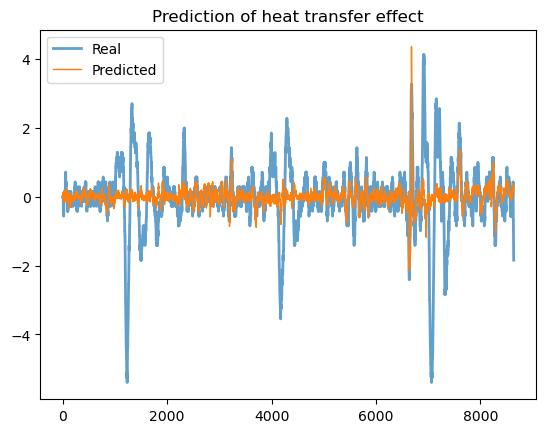

In [85]:
examp_preds = model.predict(examp_X)

plt.plot(examp_Y[-9000:-1], linewidth=2.0, alpha=0.7, label='Real')
plt.plot(examp_preds[-9000:-1], linewidth=1.0, alpha=1.0, label='Predicted')

plt.title('Prediction of heat transfer effect')
plt.legend(loc='upper left')
plt.show()

## Deploy ANN

In [64]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
    )),
    layers.Dense(
        units=128,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(
        units=128,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(
        units=64,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(1, activation=None)
]

In [65]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65    

In [66]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
790/790 [==============================] - 5s 6ms/step - loss: 0.9181 - val_loss: 0.7553
Epoch 2/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8428 - val_loss: 0.7227
Epoch 3/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8362 - val_loss: 0.7094
Epoch 4/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8282 - val_loss: 0.6977
Epoch 5/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8192 - val_loss: 0.6997
Epoch 6/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8208 - val_loss: 0.7108
Epoch 7/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8129 - val_loss: 0.6841
Epoch 8/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8144 - val_loss: 0.6934
Epoch 9/20
790/790 [==============================] - 4s 6ms/step - loss: 0.8131 - val_loss: 0.7090
Epoch 10/20
790/790 [==============================] - 4s 5ms/step - loss: 0.8097 - val_loss: 0.6893

270/270 [==============================] - 0s 2ms/step


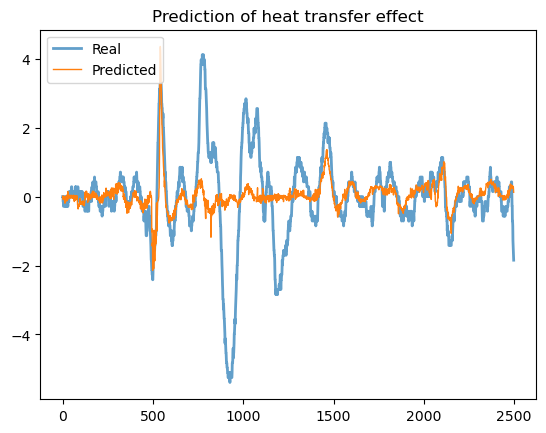

In [68]:
examp_preds = model.predict(examp_X)

plt.plot(examp_Y[-2500:-1], linewidth=2.0, alpha=0.7, label='Real')
plt.plot(examp_preds[-2500:-1], linewidth=1.0, alpha=1.0, label='Predicted')

plt.title('Prediction of heat transfer effect')
plt.legend(loc='upper left')
plt.show()

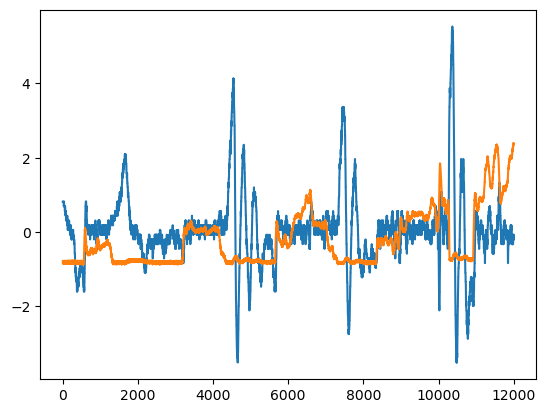

In [99]:
plt.plot(data.temperatures.TA01_GT10X_GM10X.values[-12000:])#rolling(window=200,center=True).mean().values[-12000:])
#plt.plot(data.temperatures.DC_GT401_GM401.values[-6000:])
plt.plot(data.flow.TA01_GP101_default.values[-12000:])

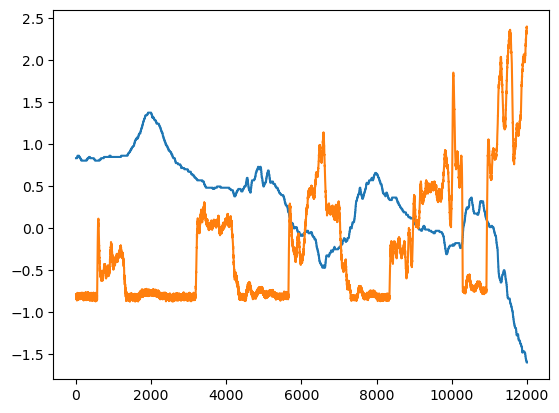

In [87]:
plt.plot(data.temperatures.DC_GT301_damped.values[-12000:])
plt.plot(data.flow.TA01_GP101_default.values[-12000:])